In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import update_mean_single, init_env, plot

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

ImportError: cannot import name 'plot' from 'data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs' (c:\Users\Hot Mexican\source\repos\aj_python_tool_lib\data_processing\neural_networks\RL_Reinforced_Learning\RL_funcs.py)

***
*   For systems where system dynamics is not available we cannot use Bellman equations to derive state values.

*   Monte Carlo (MC) is a method that avoids knowing system dynamics by computing estimates based on many samples.

*   For example this is a method that use Dynamic Programming (DP) for estimating Markov Decision Process'es (MDP) optimal state values:

    $$v_{\ast}^{k+1}(s) = \underset{a \in A}{\mathrm{max}} \ q_{\ast}(s,a) = \underset{a \in A}{\mathrm{max}} \ \sum_{r \in R} \sum_{s^\prime \in S} p(s^\prime, r|s,a) \cdot \biggl[ r + \gamma \cdot v_{\ast}^{k}(s^\prime)\biggr]$$ 

    It is reliant on knowing system dynamics $p(s^\prime,r|s,a)$ and makes an estimate of $v_{\ast}^{k+1}(s)$ based on previous estimates for neighboring states $v_{\ast}^{k}(s^\prime)$.

    Making estimates based on estimates is called "bootstrapping". Disadvantages of bootstrapping is that poor quality of prior estimate can degrade result of update rule.

*   MC, instead, can be "released" on a specific state (node), explore possible transitions, and extract particular state value without need to know state values of its neighbors.

*   Without a system model we can estimate action (state-action pair) values $q_\pi(s,a)$, since greedy policy can be extracted via
    $$\pi(s) = \underset{a \in A(s)}{\mathrm{argmax}} \ q_{\pi}(s,a)$$

*   That model would work, but only under specific condition: that we were to sample all possible <b>state-action pair starts</b>.

    This approach is called <i>Exploring Starts (ES)</i>.
    
    Under EC MC we can expect MC to visit all possible $(s,a)$ combinations given that we record many episodes.

    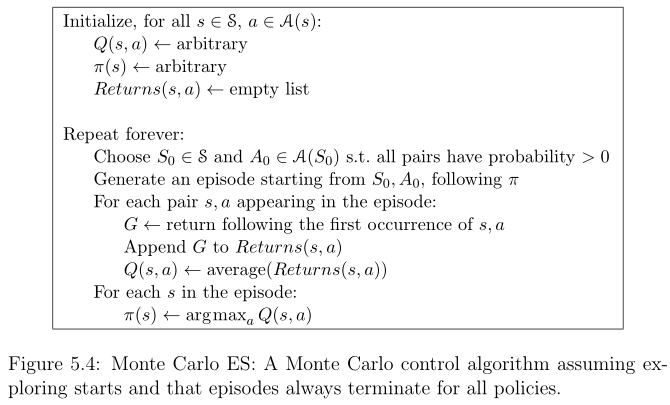
    
*   In real application use of EC MC is often impossible, so we should introduce a policy that allows for some exploration. 

    Additionally, we can transform this method to problem of Control, by shaping policy to be greedy with respect to latest $q(s,a)$. 
    
    Yet, we keep $\epsilon$ stochastisity for non-greedy actions to keep exploring.

    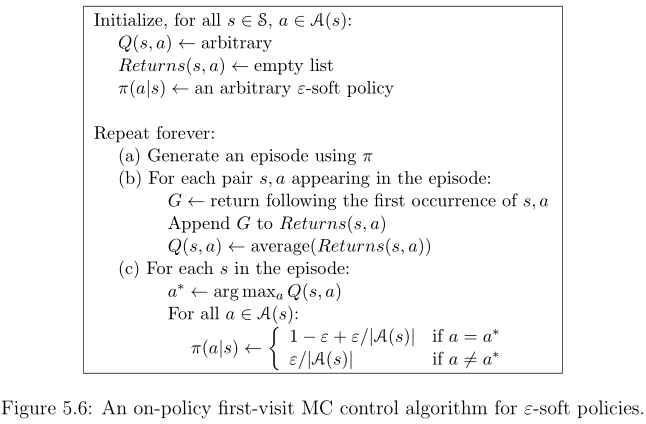


*   Term <i>First-visit</i> means that if during one episode agent returns to previously visited state, we dont include rewards related to later visits into average.

    <i>Every-visit</i> does include all rewards from repeated visits into average.
    
*   <i>on-policy</i> means that algorithm forms expectation of $q(s,a)$ based on current policy. 
    
    While this sounds like obvious and only meaningful strategy, later we will see that its not the only way (<i>off-policy</i>). 
    
    In fact, we can learn $q_\pi(s,a)$, for some policy $\pi$, based on episodes which resulted by following some other policy $\mu$.
    
    It is done by using <i>Importance Sampling</i> theorem.

*   We will also see the term <i>Incremental</i> which will refer to updates to policy being made on per one-episode basis, not on per batch-of-episodes basis.

    More extreme version is <i>Online</i> in which adjustments are made before reaching episode end. But its not used in MC algorithms.

<b>Resources: </b>

* book by Sutton and Bartol
* [RL Course by David Silver - Lecture 4: Model-Free Prediction](https://www.youtube.com/watch?v=PnHCvfgC_ZA)
* https://ai.stackexchange.com/questions/10812/what-is-the-difference-between-first-visit-monte-carlo-and-every-visit-monte-car
* [RL Chapter 5 Part4 (Importance sampling in off-policy Monte-Carlo methods of reinforcement learning)](https://www.youtube.com/watch?v=sYfnf6pvioA)

* [RL Chapter 5 Part5 (Off-policy Monte-Carlo methods, weighted importance sampling and recursions)](https://www.youtube.com/watch?v=6-OU-c1fUlY)
* https://medium.com/@Andrew_D./reinforcement-learning-model-for-blackjack-a29817218d53 (win rate)

# On-policy:
## <b>first-visit</b> $\epsilon$-soft MC control

In [5]:
BJ = init_env('Blackjack-v1', sab=True)
BJ.get_policy_soft()
BJ.get_Qsa(random = False, val = 0.5);

In [3]:
def on_policy_first_visit_MC(env: init_env, N = 1, gamma = 1, DPlays = 250_000, NPlays = 100):

    for _ in tqdm(range(N)):
        state   = env.reset()
        trajectory  = []
        rewards     = []
        first_time  = {}
        i = 0
        while True:
            action = env.sample_action_policy(state)
            state_action        = state + (action,)
            state, reward, done = env.step(action)
            trajectory.append(state_action)
            rewards.append(reward)
            if state_action not in first_time: first_time[state_action] = i
            i += 1
            if done: break
        
        w = ([gamma]*len(rewards))**np.arange(len(rewards)) # [g^0, g^1,...]
        rewards *= w

        for state_action, start_index in first_time.items():
            mean_reward = np.sum(rewards[start_index:]) 
            env.Qsa[state_action] = update_mean_single(env.Qsa[state_action], env.num_state_visits[state_action], mean_reward)

            env.num_state_visits[state_action] += 1
            
        for state_action in trajectory:
            state = state_action[:-1]
            best_action = env.best_action(state)
            env.update_policy_soft(state, best_action)

        if env.env_iters % DPlays == 0:
            env.play_N_episodes(N=NPlays)

        env.env_iters += 1

    return


100%|██████████| 1000000/1000000 [05:08<00:00, 3245.13it/s]


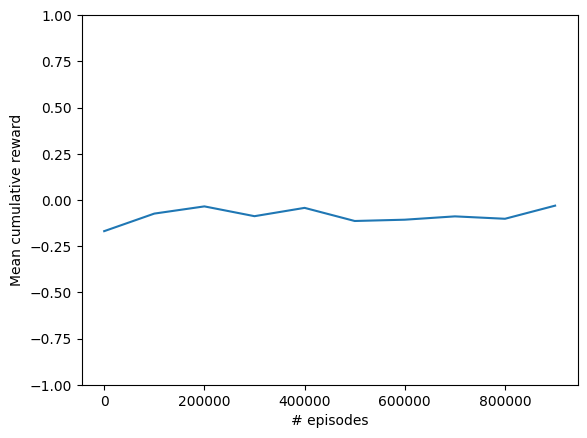

NameError: name 'plot' is not defined

In [6]:
on_policy_first_visit_MC(BJ,1_000_000, DPlays = 100_000, NPlays = 1000)
vp = BJ.Qsa.max(axis = -1)
min_hand = 11; max_hand = 22; min_deal = 1; max_deal = 11
v_ace, v_ace_no = vp[:,:,0],vp[:,:,1]

pol_ace_no     = np.argmax(BJ.policy, axis=-1)[:,:,0]
pol_ace        = np.argmax(BJ.policy, axis=-1)[:,:,1]

plt.plot(*np.array([*BJ.test_rewards.items()]).T)
plt.xlabel('# episodes')
plt.ylabel('Mean cumulative reward')
plt.ylim(-1,1)
plt.show()

plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent= [min_hand,max_hand,min_deal,max_deal])

BJ.env_iters

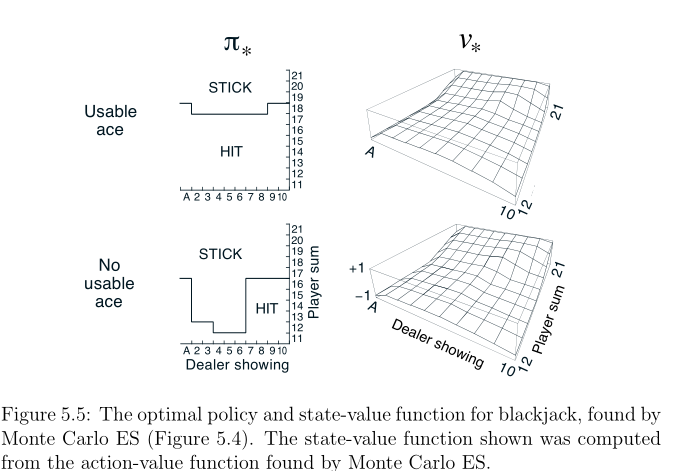

## <b>every-visit</b> $\epsilon$-soft MC control

In [10]:
def on_policy_every_visit_MC(env: init_env, N = 1, gamma = 1, DPlays = 250_000, NPlays = 100, eps_cap = 0.1, eps_decay = 0.9995):
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state   = env.reset()
        state_reward_trajectory = []
        
        while True:
            action              = env.sample_action_policy(state)
            state_action        = state + (action,)
            state, reward, done = env.step(action)
            state_reward_trajectory.append((state_action, reward))
 
            if done: break
        
        G = 0
        for state_action, reward in reversed(state_reward_trajectory):
            G = gamma*G + reward
            env.Qsa[state_action] = update_mean_single(env.Qsa[state_action], env.num_state_visits[state_action], G)
            env.num_state_visits[state_action] += 1
            
        for state_action,_ in state_reward_trajectory:
            state = state_action[:-1]
            best_action = env.best_action(state)
            env.update_policy_soft(state, best_action)

        if env.env_iters % DPlays == 0 and i > 0:
            env.get_policy_Qsa_greedy()
            env.play_N_episodes(N=NPlays, greedy_policy=True)

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps * eps_decay)
        tq_iter.set_postfix(eps=env.eps)
    return

In [31]:
BJv2 = init_env('Blackjack-v1', sab=True)
BJv2.get_policy_soft()
BJv2.get_Qsa(random = False, val = 0);

100%|██████████| 1000000/1000000 [07:15<00:00, 2293.99it/s]


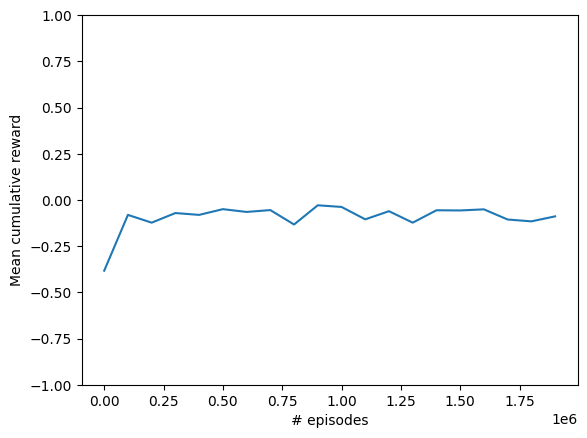

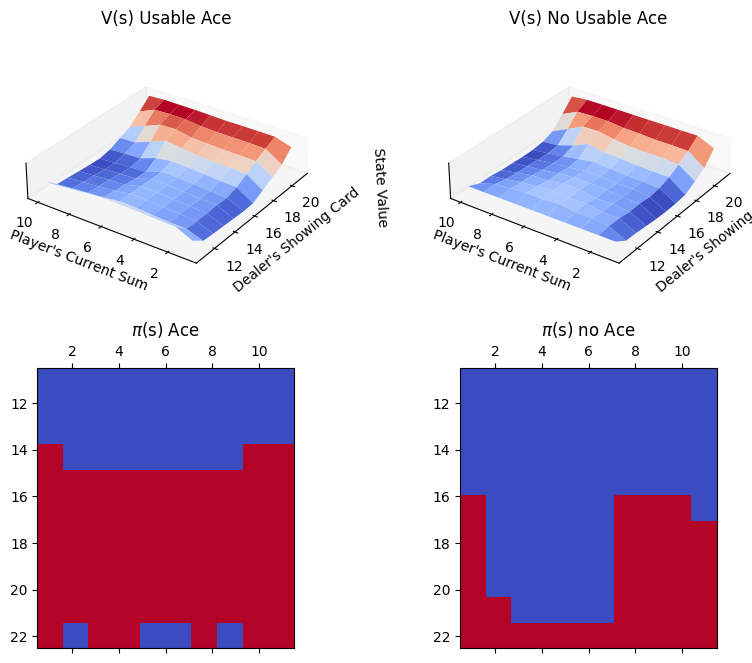

In [35]:
on_policy_every_visit_MC(BJv2,1_000_000, DPlays = 100_000, NPlays = 1000)
vp = BJv2.Qsa.max(axis = -1)
min_hand = 11; max_hand = 22; min_deal = 1; max_deal = 11
v_ace, v_ace_no = vp[:,:,0],vp[:,:,1]

pol_ace_no     = np.argmax(BJv2.policy, axis=-1)[:,:,0]
pol_ace        = np.argmax(BJv2.policy, axis=-1)[:,:,1]

plt.plot(*np.array([*BJv2.test_rewards.items()]).T)
plt.xlabel('# episodes')
plt.ylabel('Mean cumulative reward')
plt.ylim(-1,1)
plt.show()
plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent= [min_hand,max_hand,min_deal,max_deal])

# Off-policy
## Incremental every-visit MC <b>Policy-evaluation (Prediction)</b>:

Off-policy prediction allows to construct an estimate of $q_\pi(s,a)$ for policy $\pi$ based on episodes that were recorded by following other policy $\mu$.

This requires for policy $\mu$ to occasionally perform same actions as $\pi$ (called <i>assumption of coverage</i>), which can be done if policy $\mu$ is exploratory.

Here is  a rough sketch how and why it works:

***
Importance sampling allows to estimate expected value, of a random variable with one distribution $x \sim \pi$, by sampling other distribution $x \sim \mu$. 
$$\mathbb{E}_\pi[X] = \sum_x x \cdot \pi(x) = \sum_x \left(x \frac{\pi(x)}{\mu(x)}\right) \cdot \mu(x) = \mathbb{E}_\mu \left[X \frac{\pi(X)}{\mu(X)}\right] $$
This shows that you can get estimate mean value of $\pi$ by scaling samples generated from $\mu$ with so-called <i> likelihood ratio</i>
$$\rho(x) = \frac{\pi(x)}{\mu(x)} = \frac{p(X = x| \pi)}{p(X = x| \mu)}$$ 
Rough idea, is that if sample $x$ has a lower likelihood of emerging from $\mu$ than from $\pi$, then the ratio:
$$\rho(x) \gt 1$$
Thus the weight of sample $x$, coming from $\mu$, is 'boosted' to compensate in difference in distributions.

This can be extended to expectations of functions of random variable:
$$\mathbb{E}_\pi[h(X)] = \mathbb{E}_\mu \left[h(X) \frac{\pi(X)}{\mu(X)}\right] $$
And to conditioning:
$$\mathbb{E}_\pi[h(X)|Y] =  \mathbb{E}_\mu \left[h(X) \frac{\pi(X)}{\mu(X)}\bigg|Y\right] $$
Application to RL:
***

Since in MC RL we are estimating $V(s)$ as a sum of discounted values $G$ for each state $s$, we can apply importance sampling there.

What is the likelihood associated with getting reward $G_T$ at episode terminal time $T$, given you start at some time $t$? And is it different for different policies?

We know that it is a chain (Markov Chain) of probabilistic events, a trajectory of states, actions and rewards:
$$S_t,A_t, R_t, S_{t+1}, A_{t+1}, \dots, R_T, S_T$$
And probability of getting from $S_t$ to state $S_{t+1}$ via chain of intermediate actions is:

$$P(A_t, R_t, S_{t+1}|S_t,A_t\sim \pi, R_t) = \pi(A_t|S_t)P(S_{t+1},R_{t+1}|S_t, A_t)$$
Via Markov property there is no history and for second piece of chain
$$P(A_{t+1}, R_{t+1}, S_{t+2}|S_{t+1},A_{t+1}\sim \pi, R_{t+1}) = \pi(A_{t+1}|S_{t+1})P(S_{t+2},R_{t+2}|S_{t+1}, A_{t+1})$$
and transition from state $S_t$ to state $S_{T}$ can be describe as
$$P(A_t, R_t, S_{t+1}, A_{t+1}, \dots, R_T, S_T|S_t,A \sim \pi) = \pi(A_t|S_t)P(S_{t+1},R_{t+1}|S_t, A_t)\cdot \pi(A_{t+1}|S_{t+1})P(S_{t+2},R_{t+2}|S_{t+1}, A_{t+1}) \dots=$$
$$=\prod_{k=t}^{T-1}\pi(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)$$
The ratio of this event under two different policies is
$$\rho(t\rightarrow T) = \frac{P(\dots A \sim \pi) }{P(\dots A \sim \mu)  } = \frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)}=
\frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)}$$
Which is independent of MDP model, but only includes both policies

Roughly speaking we can calculate value state estimate  $V(s)$ as:
$$V(s) = \mathbb{E}_\pi[G_t] = \mathbb{E}_\mu \left[\rho\cdot G_t \right] \propto \sum_t \rho(t\rightarrow T) \cdot G_t =\sum_t \frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)} \cdot G_t $$

I dont show how its normalized because it involves lengthy definition of how time steps are stored and used.

It is worth to say that it can be as simple as dividing by number of relevant time steps or by 
$$\sum_t \rho(t\rightarrow T) $$

First, due to unknown/unbounded number of time steps can lead to high variance. Thats why second is preferred, although it is <b>biased</b> towards policy $\mu$ [19:24 of video](https://youtu.be/6-OU-c1fUlY?t=1166)

<b>Additional note:</b>

<i>Yes, importance sampling allows to scale rewards to 'normalize' rewards between two policies. 

But you may expect that behavior policy will explore irrelevant (w.r.t target policy) states, which means that target policy will not have enough samples.</i>


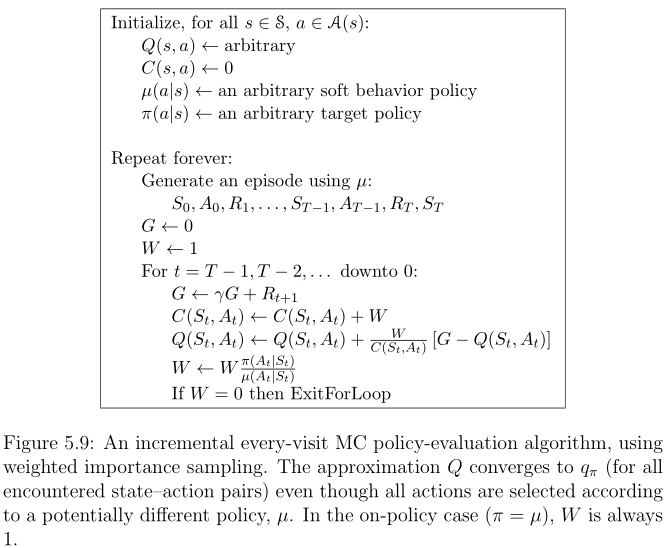

Update rule for weighted importance sampling ([see this](https://youtu.be/6-OU-c1fUlY?t=2360), but i have intermediate steps):

$$V^{(n)}(S) = \frac{\sum_{k=1}^{n-1} \rho^{k,s} G^{k,s}}{\sum_{k=1}^{n-1} \rho^{k,s}} = \frac{\sum_{k=1}^{n-1} W^{k,s} G^{k,s}}{\sum_{k=1}^{n-1} W^{k,s}} = \frac{\sum_{k=1}^{n-1} W^{k,s} G^{k,s}}{C_{n-1,s}}$$
$n\rightarrow n+ 1$, split sum
$$C_{n,s}\cdot V^{(n+1)}(S) = \sum_{k=1}^{n} W^{k,s} G^{k,s} = \sum_{k=1}^{n-1} W^{k,s} G^{k,s} + \sum_{k=n}^{n} W^{k,s} G^{k,s} =  \underline{\sum_{k=1}^{n-1} W^{k,s} G^{k,s}} + W^{n,s} G^{n,s}$$

we know one of right terms

$$\boxed{C_{n,s} \cdot V^{(n+1)}(S) = \underline{C_{n-1,s}} \cdot V^{(n)}(S)   + W^{n,s} G^{n,s}}$$
***
$$C_{n,s} = \sum_{k=1}^{n} W^{k,s} = \sum_{k=1}^{n-1} W^{k,s} + W^{n,s} = \underline{C_{n-1,s}} + W^{n,s}$$
***
$$C_{n,s} \cdot V^{(n+1)}(S) = \underline{(C_{n,s}-W^{n,s})} \cdot V^{(n)}(S) + W^{n,s} G^{n,s}=$$
$$= C_{n,s}V^{(n)}(S) - W^{n,s}V^{(n)}(S) + W^{n,s} G^{n,s} = W^{n,s}\left(G^{n,s} - V^{(n)}(S)\right) + C_{n,s}V^{(n)}(S)$$
div by $C_{n,s}$
$$\boxed{V^{(n+1)}(S) = V^{(n)}(S) + \frac{W^{n,s}}{C_{n,s}}\left(G^{n,s} - V^{(n)}(S)\right)}$$

NOTE: 
*   We are going backwards from reward time,
*   at first iteration, for Q(s,a) first term in product $\frac{\pi(A_{0}|S_{0})}{\mu(A_{0}|S_{0})} = 1/1= W$ is irrelevant, because action is already cast
*   $C(s,a)$ is normalization, in this case counting times

In [73]:
BJoff = init_env('Blackjack-v1', sab=True)
BJoff.get_policy_soft(eps = 0.2);
BJoff.get_Qsa()

In [42]:
def off_policy_every_visit_MC(env: init_env, policy_target, N = 1, gamma = 1, DPlays = 250_000, NPlays = 100):
    for _ in tqdm(range(N)):
        
        state   = env.reset()
        state_reward_trajectory = []
        (W,G)   = (1,0)

        while True:
            action                  = env.sample_action_policy(state)
            state_action            = state + (action,)
            state,  reward, done    = env.step(action)
            state_reward_trajectory.append((state_action, reward))
            if done: break
        
        for state_action, reward in reversed(state_reward_trajectory):
            G = gamma*G + reward
            env.Csa[state_action] += W
            env.Qsa[state_action] += W/env.Csa[state_action]*(G-env.Qsa[state_action])
            W *= policy_target[state_action]/env.policy[state_action]

            if W < 0.0001: 
                break
            
        if env.env_iters % DPlays == 0:
            env.play_N_episodes(N=NPlays, greedy_policy=False)

        env.env_iters += 1
    return

100%|██████████| 1000000/1000000 [05:15<00:00, 3171.87it/s]


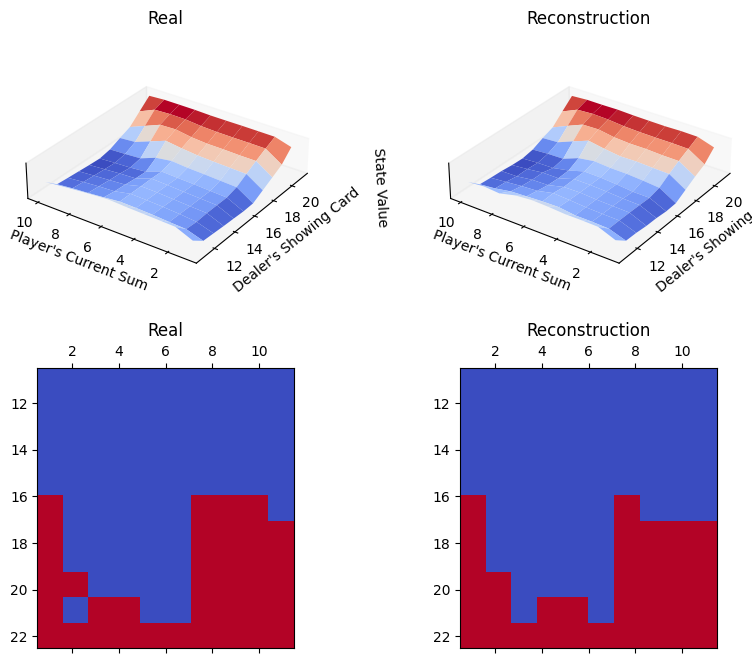

In [83]:
off_policy_every_visit_MC(BJoff,BJ.policy, 1_000_000, DPlays = 10000000);
val_OG  = BJv2.Qsa.max(axis = -1)
val_REC = BJoff.Qsa.max(axis = -1)
pol_OG  = np.argmax(BJv2.Qsa, axis=-1)
pol_REC = np.argmax(BJoff.Qsa, axis=-1)
lb1 = ['Real','Reconstruction']
lb2 = ['Real','Reconstruction']
plot(val_OG[:,:,0], val_REC[:,:,0], pol_OG[:,:,0], pol_REC[:,:,0], extent= [min_hand,max_hand,min_deal,max_deal],lables1=lb1, lables2=lb2)

# Off-policy every-visit MC control
## Via weighted importance sampling

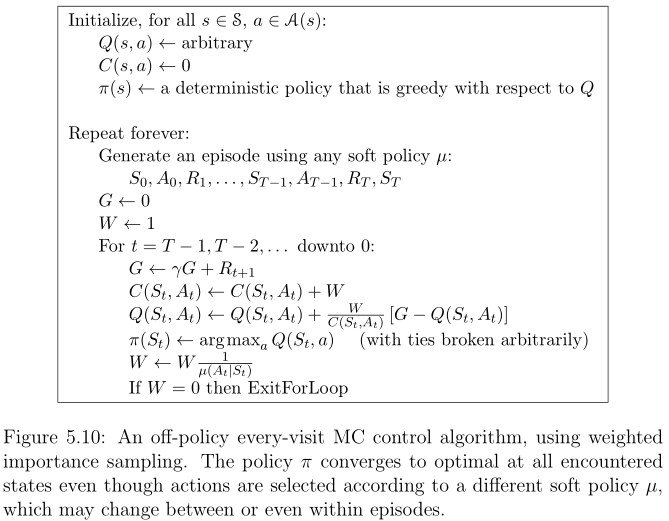

NOTE:

Because target policy is deterministic
$$\pi(S_T) = A_{optimal}\rightarrow\pi(A_t,S_t) = \pi(A_{optimal}|S_T) = 1  $$

$$\frac{\pi(A_t,S_t)}{\mu(A_t,S_t)} = \frac{1}{\mu(A_t,S_t)} $$

In [14]:
BJoffC = init_env('Blackjack-v1', sab=True)
BJoffC.get_Qsa(random=True)     # random Q(s,a)
BJoffC.get_policy_Qsa_greedy()  # not action distr
BJoffC.get_policy_soft(eps = 0.2);  # soft behavior self.policy

In [50]:
def off_policy_every_visit_MC(env: init_env, N = 1, gamma = 1, DPlays = 250_000, NPlays = 100):
    for _ in tqdm(range(N)):
        
        state   = env.reset()
        state_reward_trajectory = []

        while True:
            action                  = env.sample_action_policy(state)   # via behavior self.policy
            state_action            = state + (action,)
            state,  reward, done    = env.step(action)
            state_reward_trajectory.append((state_action, reward))
            if done: break
        
        (W,G)   = (1,0)
        
        for state_action, reward in reversed(state_reward_trajectory):
            G = gamma*G + reward
            env.Csa[state_action] += W
            env.Qsa[state_action] += W/env.Csa[state_action]*(G-env.Qsa[state_action])
            state, action = state_action[:-1], state_action[-1]
            best_action = env.best_action(state) #w.r.t Qsa
            env.policy_greedy[state] = best_action
            if best_action != action: break 
            W *= 1/env.policy[state_action]     # may grow to infty


            if W < 1e-5: break

        if env.env_iters % DPlays == 0:
            env.play_N_episodes(N=NPlays, greedy_policy=True)

        env.env_iters += 1
    return

100%|██████████| 2000000/2000000 [12:46<00:00, 2610.59it/s]


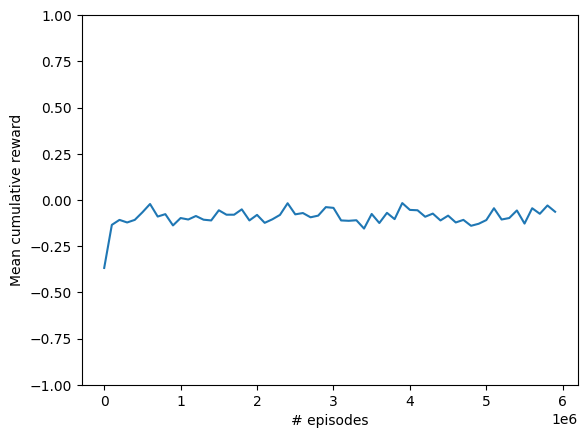

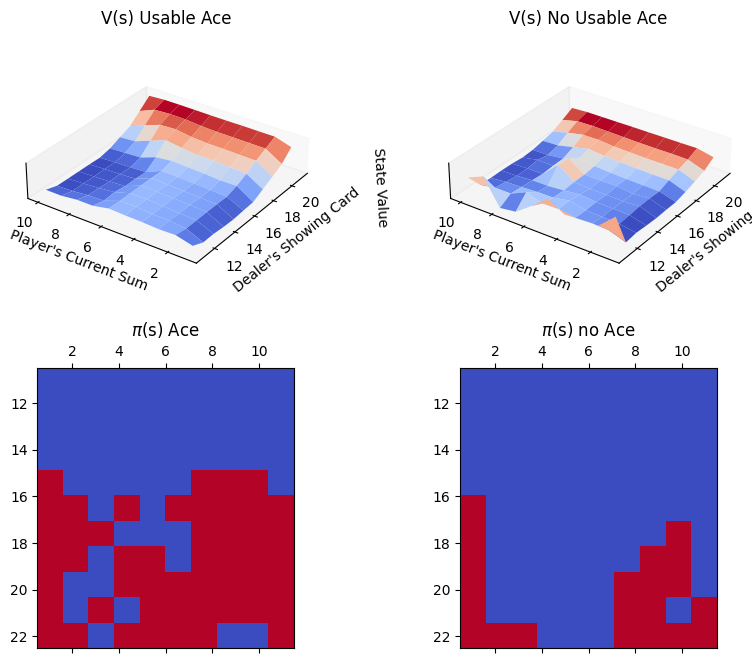

In [25]:
off_policy_every_visit_MC(BJoffC, 2_000_000, DPlays = 100_000, NPlays = 1000)


vp = BJoffC.Qsa.max(axis = -1)
min_hand = 11; max_hand = 22; min_deal = 1; max_deal = 11
v_ace, v_ace_no = vp[:,:,0],vp[:,:,1]

pol_ace_no     = BJoffC.policy_greedy[:,:,0]
pol_ace        = BJoffC.policy_greedy[:,:,1]

plt.plot(*np.array([*BJoffC.test_rewards.items()]).T)
plt.xlabel('# episodes')
plt.ylabel('Mean cumulative reward')
plt.ylim(-1,1)

plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent= [min_hand,max_hand,min_deal,max_deal])

# Cliff Walking
* https://www.gymlibrary.dev/environments/toy_text/cliff_walking/
* observable space = 4x12 states as flattened matrix. start at i,j (3,0) = index 36, goal at (3,11). allr est boottom sends you back to start.
* reward -1 for each step
* actions top, right, bottom,left = (0,1,2,3)
Comments:


* easy to fall down from the cliff. Means agent needs a lot of exploration =  long trajectories.
* generally needs to move the right. but you fall at start. need stochastisity
* so you need to have a lot of exploration at the start and then tighten eps for deterministic policy.
* Its not crystal clear how to setup this eps-decay. (ended up scaling it by 0.999 each iteration and have a low cap)
* had to apply test runs with deterministic policy, but if he falls -> 
* -> had to limit number of iterations for tests because of long trajectories
* had to set init policy to move top to avoid falling from the cliff

***
Conclusions:
1. loops in trajectory make things difficult
1. stochastsity in actions make agent avoid the cliff edge and move deeper
1. gradually reducing eps does not guarantee that algo will converge to optimum, need large eps > 0.1 to keep exploring
1. policy initialization plays more important role, maybe even dominant.

In [11]:

env_CW = init_env("CliffWalking-v0", eps=0.4)
env_CW.get_Qsa(random=True)     # random Q(s,a)
# env_CW.get_policy_Qsa_greedy()  # not action distr
env_CW.get_policy_soft(random= False, action = 0); 

In [48]:

on_policy_every_visit_MC(env_CW,50_000, DPlays = 500, NPlays = 150, eps_cap=0.3,eps_decay=0.999, gamma=0.99)

100%|██████████| 50000/50000 [04:15<00:00, 195.32it/s, eps=0.3]


array([0.075, 0.775, 0.075, 0.075])

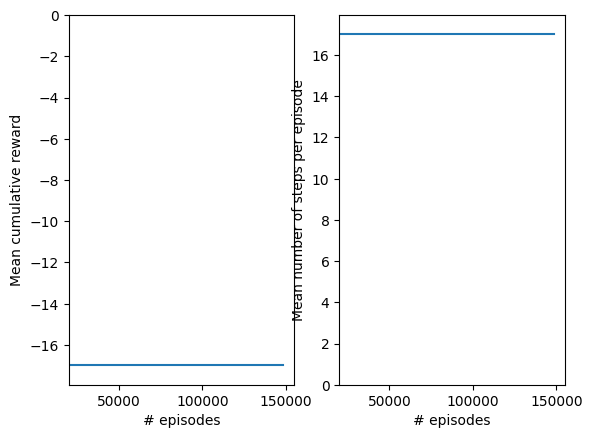

In [51]:
fltr = 20000
plt.subplot(1,2,1)
plt.plot(*np.array([(i,r) for i,r in env_CW.test_rewards.items() if i >fltr]).T)
plt.xlabel('# episodes')
plt.ylabel('Mean cumulative reward')
plt.xlim(left = 20000)
plt.ylim(top = 0)
plt.subplot(1,2,2)
plt.plot(*np.array([(i,r) for i,r in env_CW.steps_per_ep.items() if i >fltr]).T)
#plt.yscale('log')
plt.xlabel('# episodes')
plt.ylabel('Mean number of steps per episode')
plt.xlim(left = 20000)
plt.ylim(0)

env_CW.policy[34]

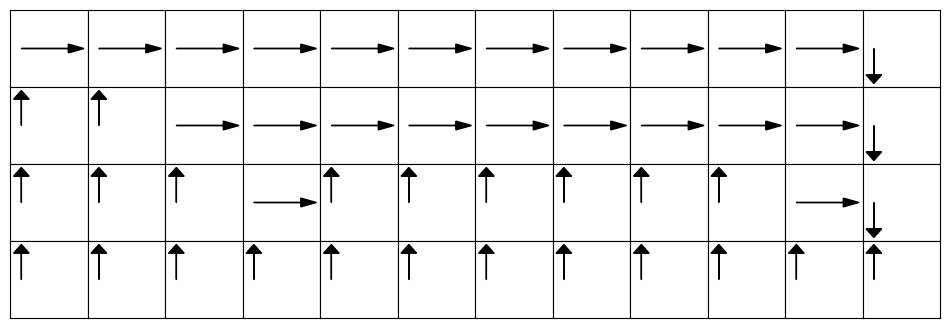

In [50]:
def plot_arrows_on_grid(A):
    # ChatGPT + modified
    fig, axes = plt.subplots(4, 12, figsize=(12,4), sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    axes = axes.flatten()
    for i,(ax,arrows) in enumerate(zip(axes,A)):
        arrows2 = arrows.copy()
        arrows2[arrows<0.5] = 0
        #if all(arrows): continue
        if arrows2[3]:  # Left arrow
            ax.arrow(0.5, 0.5, -0.3, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
        if arrows2[2]:  # Bottom arrow
            ax.arrow(0.5, 0.5, 0, -0.3, head_width=0.1, head_length=0.1, fc='k', ec='k')
        if arrows2[1]:  # Right arrow
            ax.arrow(0.5, 0.5, 0.3, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
        if arrows2[0]:  # Top arrow
            ax.arrow(0.5, 0.5, 0, 0.3, head_width=0.1, head_length=0.1, fc='k', ec='k')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
plot_arrows_on_grid(env_CW.policy)

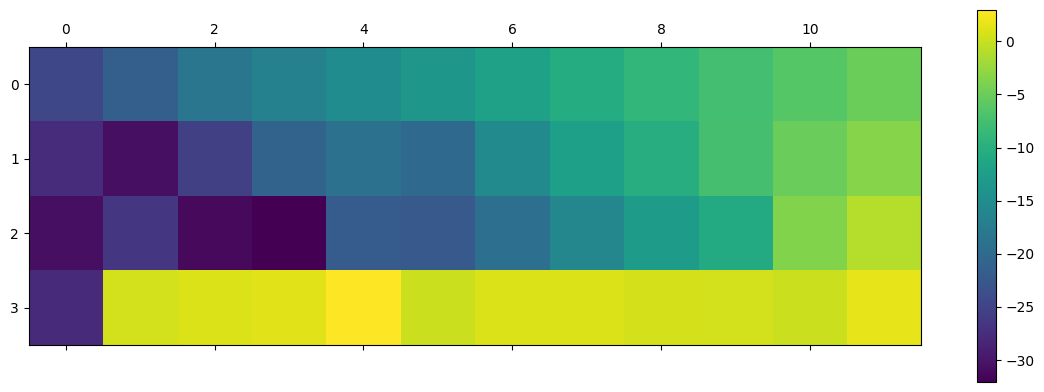

In [52]:
c = plt.matshow(env_CW.Qsa.max(axis = -1).reshape(4,12))
plt.colorbar(c)